<center>
    <h1>Prodigy InfoTech Internship</h1>
    <h3>Problem Statement 4 : Develop a hand gesture recognition model to accurately identify and classify various hand gestures from images </h3>
</center>

### Importing Necessary Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Extracting Gesture Categories from Dataset Directory Structure

In [2]:
# Set the path to the main dataset directory
path = "C:/Users/DELL/Desktop/ML_04/leapGestRecog"

# List all folders in the main dataset directory
folders = os.listdir(path)

# List all files and folders in the subdirectory "01", assuming it contains gesture categories
inner_folders = os.listdir(path+"/01")

# Initialize an empty list to store category names
categories=[]

# Iterate over each item in the inner_folders list
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
    
# Calculate the number of unique classes based on the length of the categories list
num_classes = len(categories)

# Output the list of categories
categories

['palm',
 'l',
 'fist',
 'fist_moved',
 'thumb',
 'index',
 'ok',
 'palm_moved',
 'c',
 'down']

### Organizing File Paths and Categories into a DataFrame

In [3]:
# Create an empty DataFrame with columns 'filepaths' and 'categories'
df = pd.DataFrame(columns=['filepaths','categories'])

# Initialize empty lists to store file paths and their corresponding categories
paths , category = [], []

# Iterate over each folder in the main dataset directory
for folder in folders:
    
    # List all subdirectories and files within the current folder
  inner_folders = os.listdir(path+'/'+folder)
  for inner_f in inner_folders:
    files = os.listdir(path+'/'+folder+"/"+inner_f)
    for file in files:
      paths.append(folder+'/'+inner_f+'/'+file)
      category.append(inner_f.split('_', maxsplit=1)[1])
        
# Assign the collected file paths to the 'filepaths' column in the DataFrame
df['filepaths'] = paths

# Assign the collected categories to the 'categories' column in the DataFrame
df['categories'] = category

### Image Dimensions, Channels, and Batch Size Configuration

In [4]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

### Visualizing a Grid of Sample Images

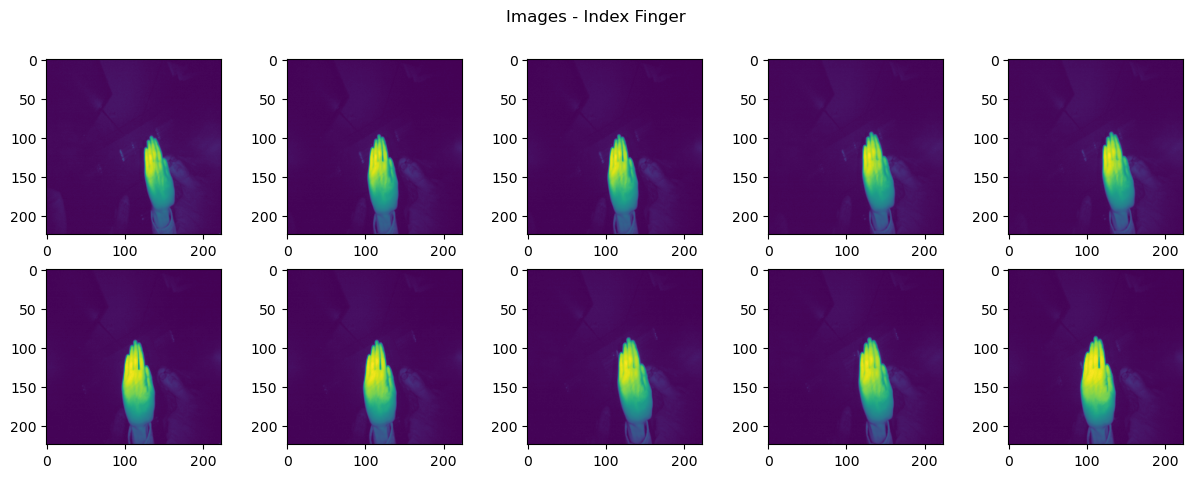

In [5]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Images - Index Finger")

for i in range(10):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  # print(img.shape)
plt.show()

### Splitting DataFrame into Training, Testing, and Validation Sets

In [6]:
# Split the DataFrame into training and testing sets with 20% of the data reserved for testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

# Further split the testing set into testing and validation sets with 50% of the test data used for validation
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)

# Display the first 5 rows of the training DataFrame
train_df[:5]

,filepaths,categories
9642,04/09_c/frame_04_09_0043.png,c
17924,08/10_down/frame_08_10_0125.png,down
1642,00/09_c/frame_00_09_0043.png,c
9670,04/09_c/frame_04_09_0071.png,c
16860,08/05_thumb/frame_08_05_0061.png,thumb


### Configuring ImageDataGenerator for Data Augmentation and Loading Training Data

In [7]:
# Create an ImageDataGenerator instance for real-time data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1/.255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)

# Create a data generator that reads images from a DataFrame and applies augmentation
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 16000 validated image filenames belonging to 10 classes.


### Setting Up Data Generator for Validation with Normalization

In [8]:
val_datagen = ImageDataGenerator(rescale=1/.255)

# Create a data generator for validation images
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


## Model Definition

In [9]:
# Define a Sequential model
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(im_size[0], im_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

### Configuring Callbacks for Early Stopping and Learning Rate Adjustment

In [10]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Model Training

In [11]:
model_hist = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


320/320 [==============================] - 174s 536ms/step - loss: 3.6666 - acc: 0.1422 - val_loss: 2.1614 - val_acc: 0.1970 - lr: 0.0010
Epoch 2/20
320/320 [==============================] - 169s 528ms/step - loss: 2.1309 - acc: 0.1921 - val_loss: 2.0494 - val_acc: 0.2240 - lr: 0.0010
Epoch 3/20
320/320 [==============================] - 183s 572ms/step - loss: 2.0660 - acc: 0.2067 - val_loss: 2.0038 - val_acc: 0.2380 - lr: 0.0010
Epoch 4/20
320/320 [==============================] - 187s 583ms/step - loss: 2.0051 - acc: 0.2333 - val_loss: 1.8571 - val_acc: 0.3110 - lr: 0.0010
Epoch 5/20
320/320 [==============================] - 206s 644ms/step - loss: 1.9263 - acc: 0.2689 - val_loss: 1.7529 - val_acc: 0.4030 - lr: 0.0010
Epoch 6/20
320/320 [==============================] - 184s 574ms/step - loss: 1.7606 - acc: 0.3319 - val_loss: 1.4914 - val_acc: 0.4835 - lr: 0.0010
Epoch 7/20
320/320 [==============================] - 209s 652ms/step - loss: 1.6230 - acc: 0.3945 - val

### Visualizing Training and Validation Accuracy and Loss Over Epochs

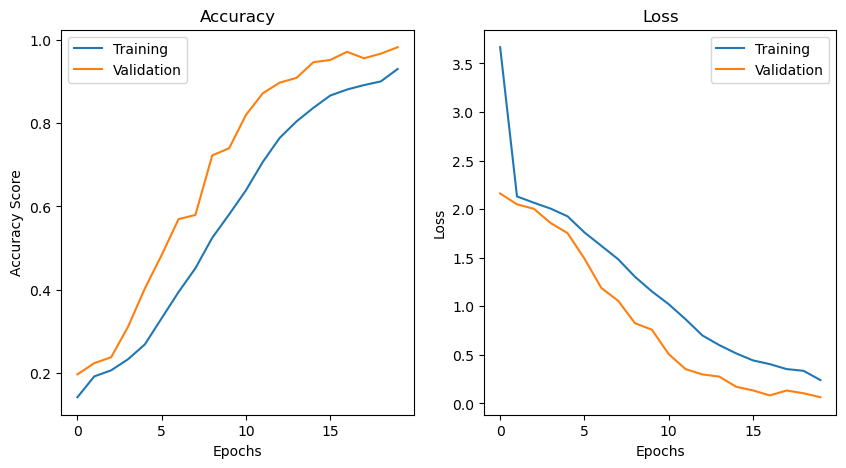

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['acc'], label='Training')
plt.plot(model_hist.history['val_acc'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_hist.history['loss'], label='Training')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Training History.jpg")
plt.show()

In [13]:
# Save the trained model to a file
model.save('hand_gesture_recognition.h5')

C:\Users\DELL\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [14]:
basic_test_generator = train_datagen.flow_from_dataframe(
    test_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


### Evaluating Model Performance on Test Data 

In [15]:
loss, acc = model.evaluate(basic_test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", acc)

40/40 [==============================] - 33s 838ms/step - loss: 0.1584 - acc: 0.9490
Testing Loss: 0.15835434198379517
Testing Accuracy: 0.9490000009536743


### Processing and Reshaping Sample Images for Inspection

In [18]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

(8, 224, 224, 1)

### Generating and Interpreting Predictions for Sample Images

In [19]:
# Predict the class probabilities for the sample images using the trained model
preds = model.predict(sample_imgs)

# Convert the probabilities to class labels by taking the index of the highest probability
preds = np.argmax(preds, axis=1)

1/1 [==============================] - 0s 294ms/step


In [20]:
preds

array([3, 7, 3, 8, 0, 9, 2, 4], dtype=int64)

### Visualizing Model Predictions for Sample Images

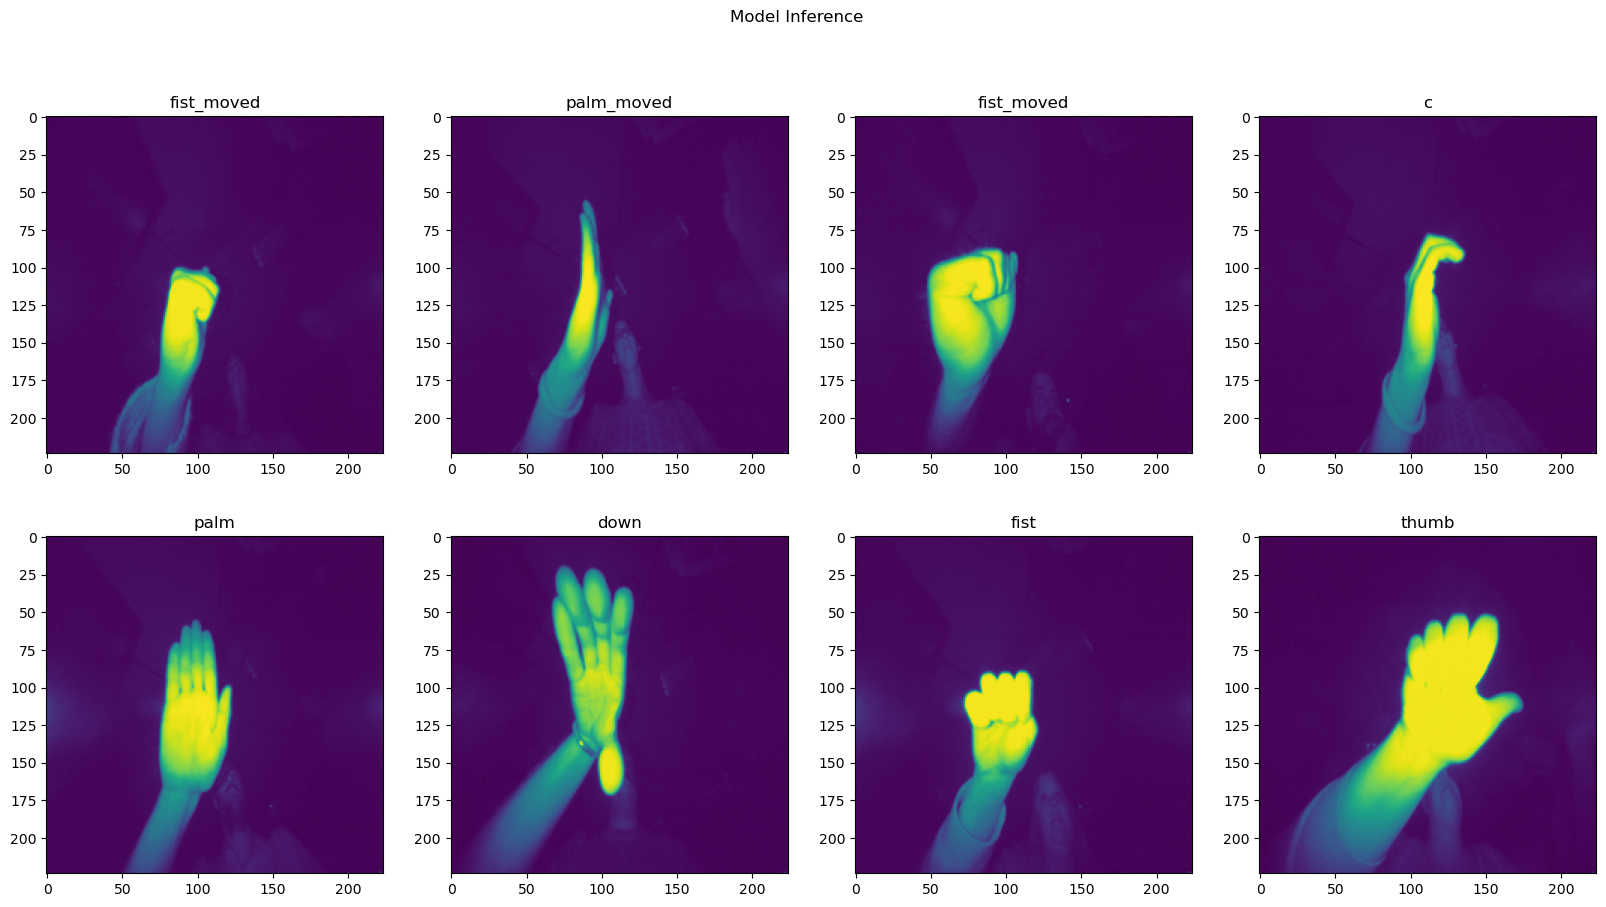

In [21]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Model Inference")
ind=1
for img in sample_imgs:
  plt.subplot(2,4,ind)
  plt.imshow(img)
  plt.title(categories[preds[ind-1]])
  ind+=1
plt.savefig("Hand Gesture model Inference.jpg")
plt.show()